In [1]:
%matplotlib inline

import numpy as np
import copy
import matplotlib.pyplot as plt
import pickle
import random
import torch
from utils import torch_from_numpy
import datetime

from config import cfg_seed, cfg_env, cfg_z_dim
seed = cfg_seed
env_str=cfg_env
# num_iter_max=200000
env_name = 'CustomPendulum-v0'
figfilenamehead = "fig_policy_optimization_"+env_str+"_iter2_"

loss_list = []
normalized_loss_list = []

print(datetime.datetime.now())

2023-06-13 08:26:37.958635


In [2]:
import gym
import custom_gym
env = gym.make(env_name)

np.random.seed(seed)
random.seed(seed)
env.seed(seed)
env.action_space.seed(seed)
torch.manual_seed(seed)

s_dim = env.reset().flatten().shape[0]
a_dim = env.action_space.sample().flatten().shape[0]
z_dim = cfg_z_dim
print(s_dim, a_dim, z_dim)

2 1 1


/home/proxima-hishinuma/anaconda3/envs/iwvi/lib/python3.8/site-packages/gym/core.py:329: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/home/proxima-hishinuma/anaconda3/envs/iwvi/lib/python3.8/site-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/home/proxima-hishinuma/anaconda3/envs/iwvi/lib/python3.8/site-packages/gym/utils/passive_env_checker.py:174: UserWarning: WARN: Future gym versions will require that `Env.reset` can be passed a `seed` instead of using `Env.seed` for resetting the environment random number generator.
  logger.warn(
/home/proxima-hishinuma/anaconda3/

In [3]:


from sac import SAC
# agent = SAC(env.observation_space.shape[0], env.action_space)
agent = SAC(env.observation_space.shape[0]+z_dim*2, env.action_space)
agent.load_checkpoint(ckpt_path="checkpoints/sac_checkpoint_custom_"+env_str+"_bamdp_weightedvae_")


offline_data = pickle.load(open("offline_data_"+env_str+".pkl","rb"))
debug_info = pickle.load(open("offline_data_debug_info_"+env_str+".pkl","rb"))
debug_info = np.array(debug_info)

Loading models from checkpoints/sac_checkpoint_custom_pendulum_bamdp_weightedvae_


In [4]:
args_init_dict = {
    "offline_data": offline_data,
    "s_dim": s_dim,
    "a_dim": a_dim,
    "z_dim": z_dim,
    #              "policy":agent.select_action,
    "mdp_policy":None,
    "bamdp_policy":agent.policy.my_np_select_action,
    "debug_info":debug_info,
    "env" : env,
    "ckpt_suffix" : env_str,
}
# import vi_base
# vi = vi_base.baseVI(args_init_dict)
import vi_iw
iwvi = vi_iw.iwVI(args_init_dict)

# iwvi.load_base(ckpt_key="unweighted")
iwvi.load(ckpt_key="policy_optimization_iter1")

dec: h_dim 48
iwvi load ckpt1, ckpt2 ckpt_iwvi_basepartpendulum_policy_optimization_iter1 ckpt_iwvi_pendulum_policy_optimization_iter1
base load ckpt ckpt_basevi_pendulum_policy_optimization_iter1
base load self.initial_belief.data.sum() tensor(-4.3481)
base load dec.state_dict()['net_phat.0.weight'].sum() tensor(-2.2502)
penalty_target_min tensor(-6.1621) penalty_target_max tensor(5198.3467)
train_loss:  -5.210190813922883
valid_loss:  0.6490851455688478
h_min_tilde -6.1621222 ell_tilde -4.038335622024537 kappa_tilde 0.0006861902754509623
success load ckpt_iwvi_basepartpendulum_policy_optimization_iter1
train_loss:  -3.5879227631092077
valid_loss:  23.76188308759928
weight_alpha 1.0 h_min_tilde -6.1621222 ell_tilde 1.8820384070324894 kappa_tilde 0.00035258159019331753


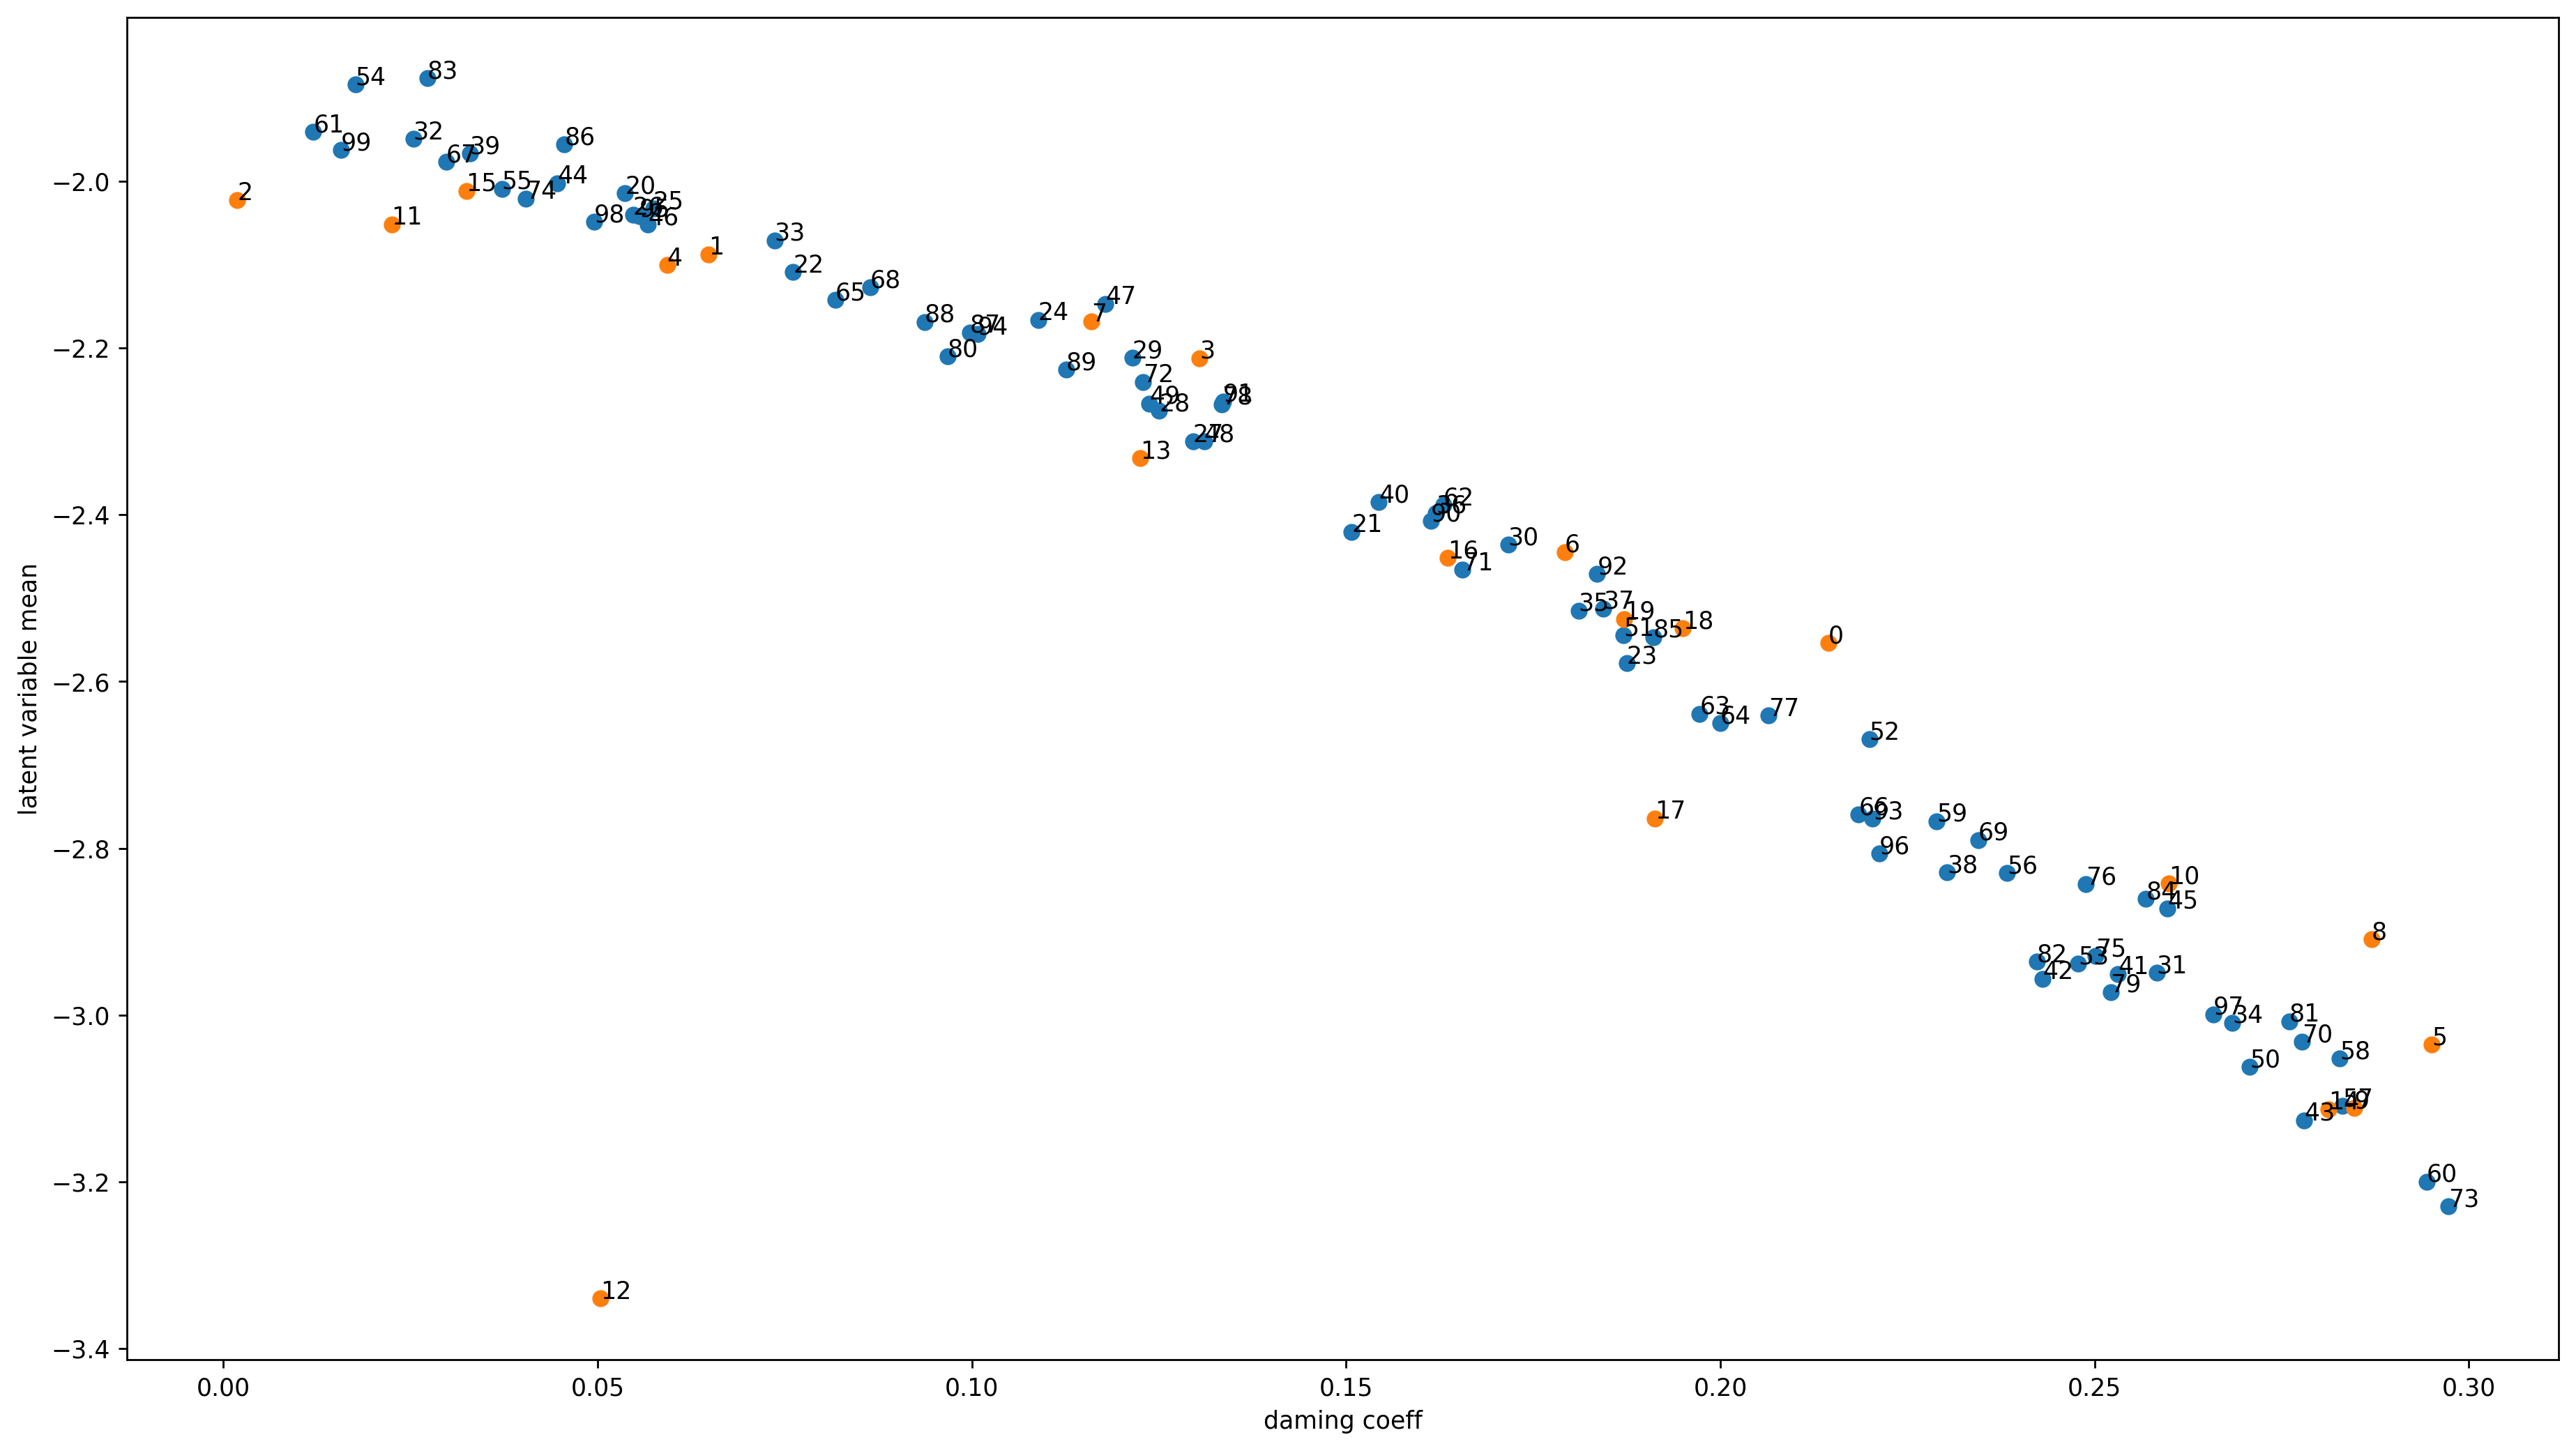

[0.2144448  0.06482685 0.00186908 0.13043746 0.05930552 0.2950202
 0.17920018 0.11597138 0.28699589 0.28469319]
[0.25988679 0.02248458 0.05039166 0.12253316 0.28127148 0.03245801
 0.1635608  0.19128307 0.19494153 0.18717483]
[0.05369217 0.15075992 0.07610389 0.18747925 0.10885608 0.05743392
 0.05473362 0.12954662 0.12503289 0.12144757]
[0.17164163 0.25830429 0.02539848 0.07363611 0.26839539 0.18106905
 0.16202242 0.18436885 0.23032741 0.03294544]
[0.15439611 0.2531121  0.24304333 0.27801621 0.04461805 0.25973247
 0.05670773 0.11783435 0.13102989 0.12374166]
[0.27072656 0.18707065 0.21989962 0.24780686 0.01766403 0.03720439
 0.238327   0.28313925 0.28277575 0.22889809]
[0.29436298 0.01202734 0.16298709 0.19724539 0.19996752 0.08174144
 0.21848083 0.02979833 0.08641105 0.23445934]
[0.27774258 0.16557793 0.12287742 0.29723905 0.04042578 0.25013441
 0.24882538 0.20646638 0.1333622  0.25213982]
[0.09677249 0.2759962  0.24226469 0.02727317 0.25685513 0.1910546
 0.04556568 0.09974855 0.093661

In [5]:
plt.figure(figsize=(18,10), dpi=250)
np_mulogvar = iwvi.mulogvar_offlinedata.numpy()
plt.xlabel("daming coeff")
plt.ylabel("latent variable mean")

plt.plot(debug_info[iwvi.validdata_num:,1], np_mulogvar[iwvi.validdata_num:,0], "o")
plt.plot(debug_info[:iwvi.validdata_num,1], np_mulogvar[:iwvi.validdata_num,0], "o")
# plt.xlim([-0.05,0.35])
for i in range(len(debug_info)):
    plt.annotate(str(i), xy=(debug_info[i,1],  np_mulogvar[i,0]))
plt.savefig(figfilenamehead+"damping_latent_"+env_str+"_iter0.png")
plt.savefig(figfilenamehead+"damping_latent_"+env_str+"_iter0.eps")
# plt.savefig(figfilenamehead+"damping_latent_"+env_str+"_iter0.pdf")
plt.show()


for i in range(10):
    print(debug_info[i*10 : (i+1)*10,1])
# plt.show()
print("摩擦係数-潜在変数")

In [6]:
iwvi.get_real_rollout_bamdppolicy_data()


 0 7.152557373046875e-07


/home/proxima-hishinuma/anaconda3/envs/iwvi/lib/python3.8/site-packages/gym/utils/passive_env_checker.py:227: DeprecationWarning: WARN: Core environment is written in old step API which returns one bool instead of two. It is recommended to rewrite the environment with new step API. 
  logger.deprecation(
/home/proxima-hishinuma/anaconda3/envs/iwvi/lib/python3.8/site-packages/gym/utils/passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(done, (bool, np.bool8)):
/home/proxima-hishinuma/anaconda3/envs/iwvi/lib/python3.8/site-packages/gym/utils/passive_env_checker.py:141: UserWarning: WARN: The obs returned by the `step()` method was expecting numpy array dtype to be float32, actual type: float64
  logger.warn(
/home/proxima-hishinuma/anaconda3/envs/iwvi/lib/python3.8/site-packages/gym/utils/passive_env_checker.py:165: UserWarning: WARN: The obs returned by the `step()` method is not within the observ


 1 3.4042863845825195

 2 3.456437587738037

 3 3.222132682800293

 4 3.2711074352264404

 5 3.2018191814422607

 6 3.2016961574554443

 7 3.0615408420562744

 8 3.245633363723755

 9 3.2212073802948

 10 3.195814371109009

 11 3.250046730041504

 12 3.109116792678833

 13 3.2024431228637695

 14 3.060140371322632

 15 3.1992075443267822

 16 3.0845096111297607

 17 3.1275620460510254

 18 3.2235143184661865

 19 3.3578224182128906

 20 3.2049899101257324

 21 3.0620877742767334

 22 3.1979260444641113

 23 3.100017547607422

 24 3.1573894023895264

 25 3.0097341537475586

 26 3.1358771324157715

 27 3.2869954109191895

 28 3.5096309185028076

 29 3.2449512481689453

 30 3.070150136947632

 31 3.227428913116455

 32 3.3826656341552734

 33 3.2620747089385986

 34 3.426853656768799

 35 3.45088529586792

 36 3.5291707515716553

 37 3.3012657165527344

 38 3.258427619934082

 39 3.1993274688720703

 40 3.109755039215088

 41 3.343660593032837

 42 3.143186330795288

 43 3.08822298049926

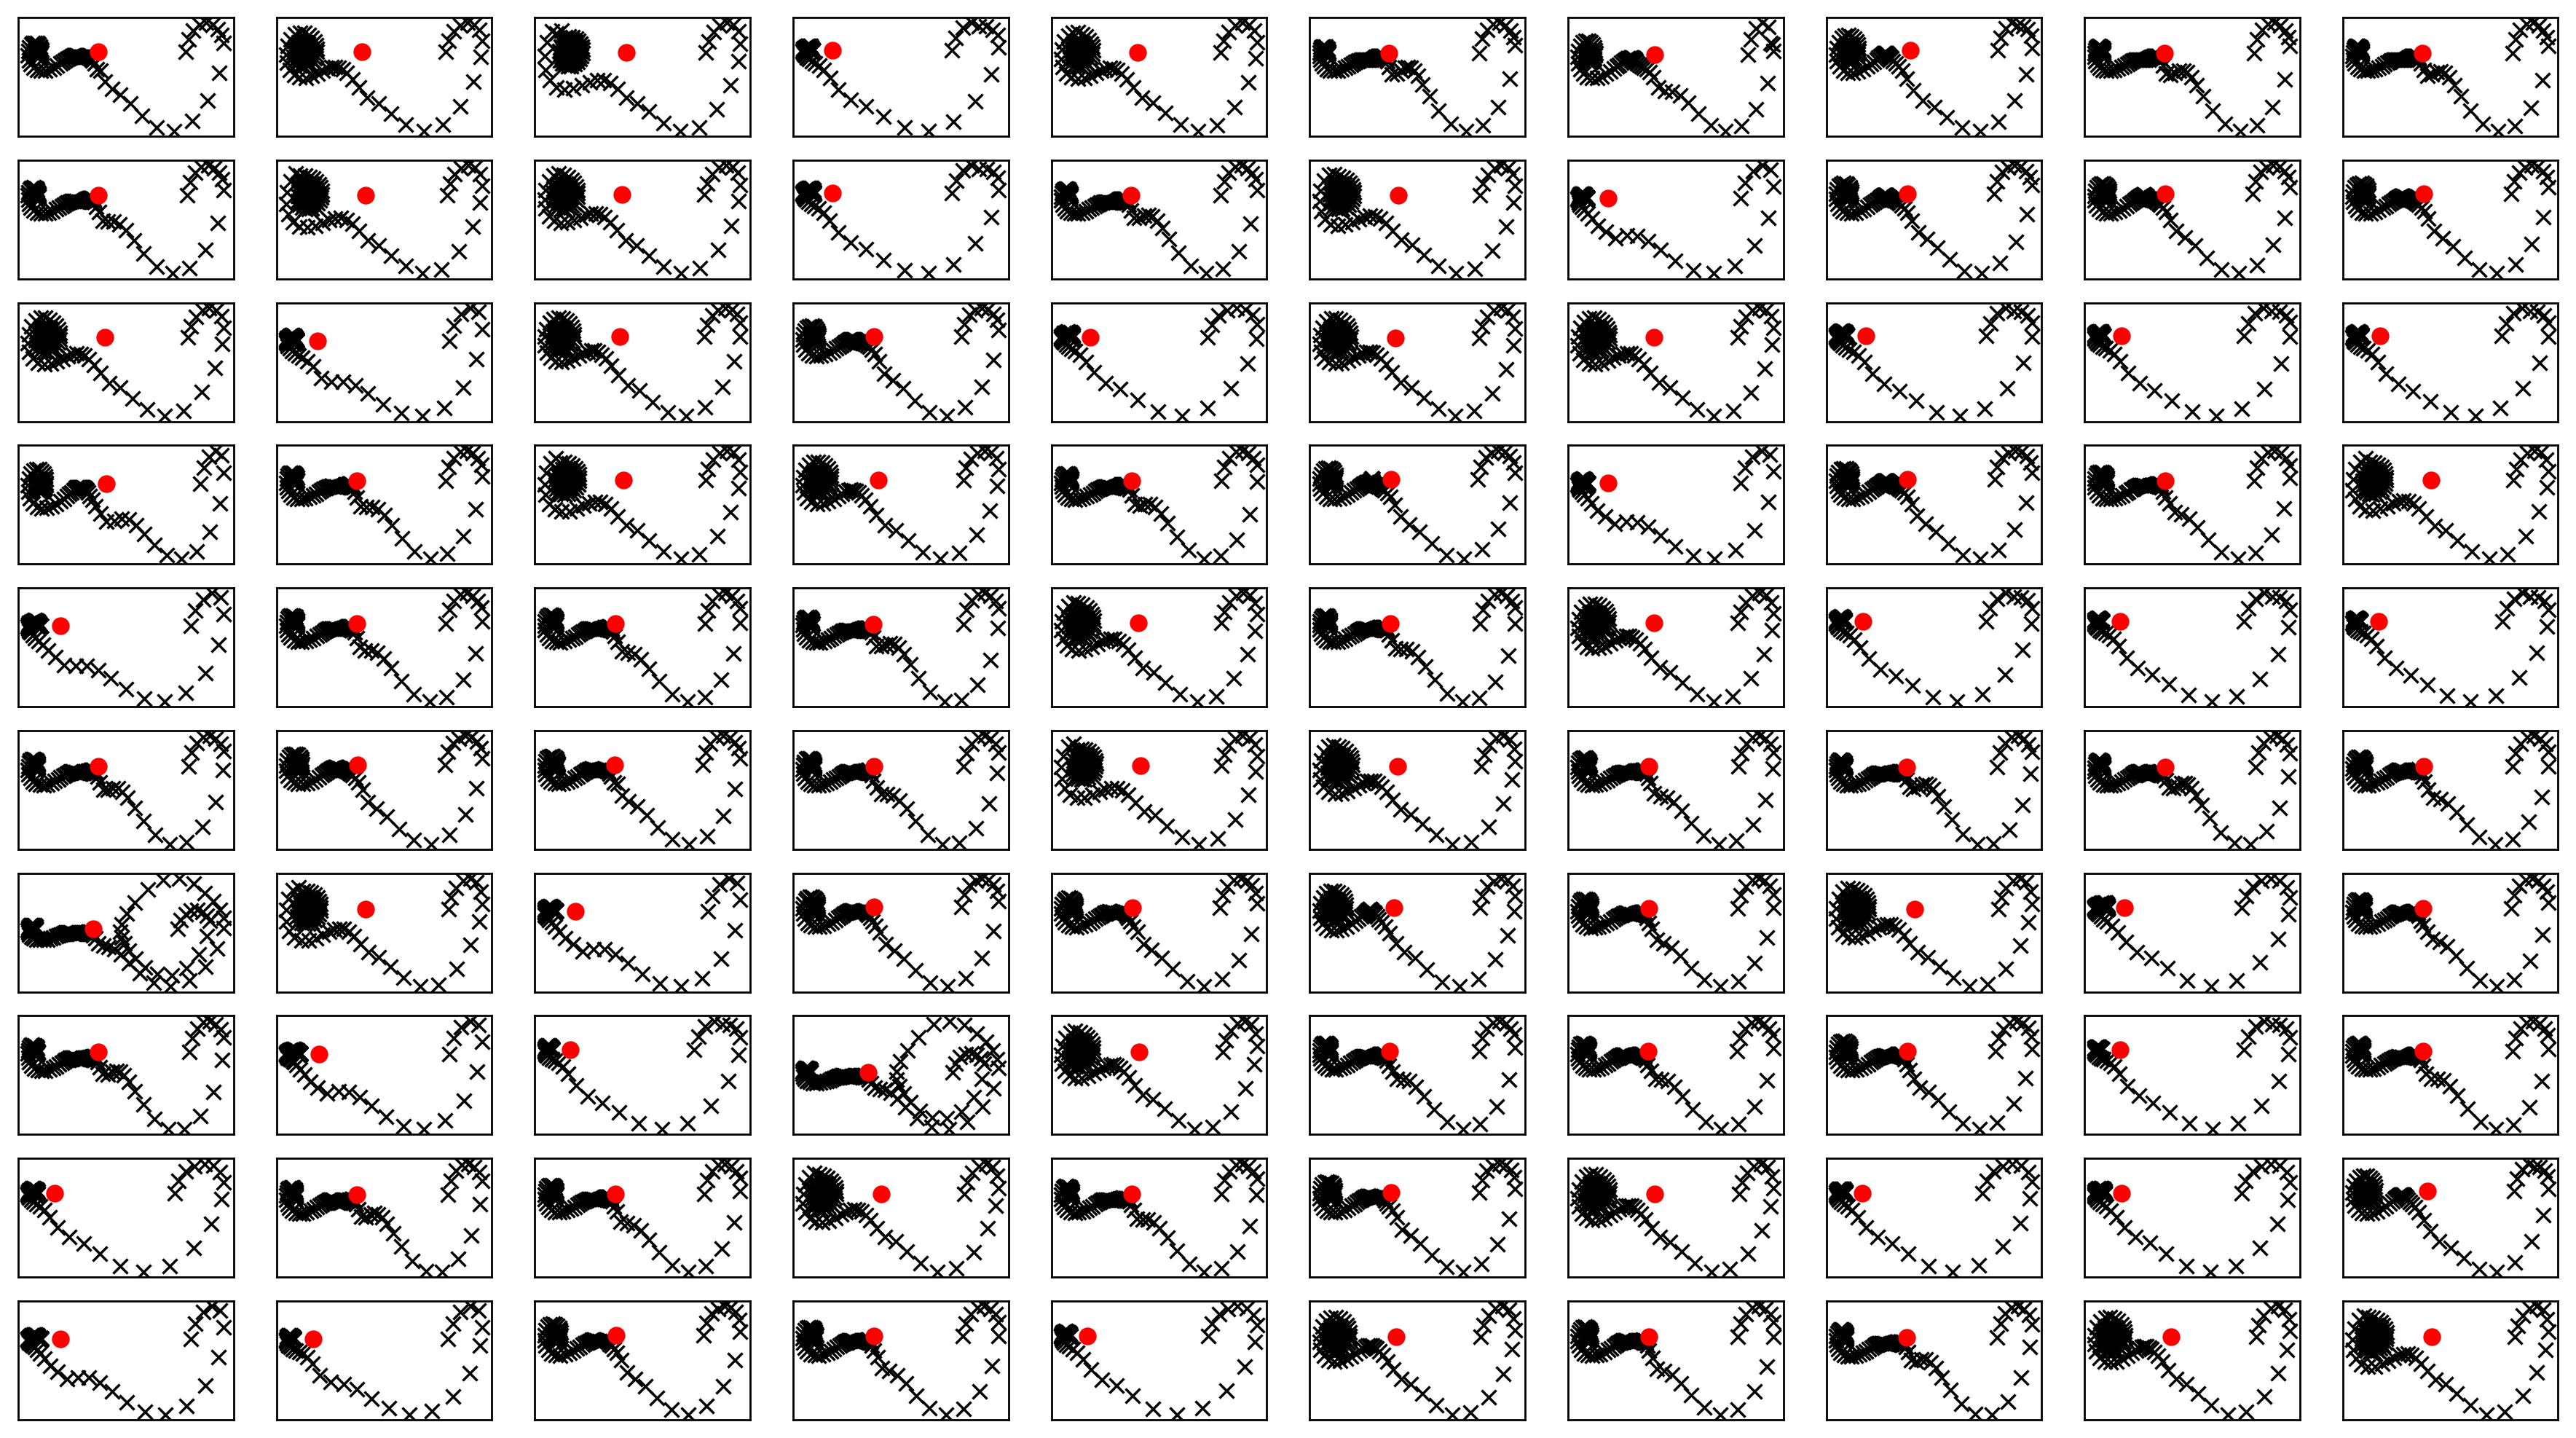

In [7]:
fig = plt.figure(figsize=(18,10), dpi=250)
fig.patch.set_facecolor('white')
ax_list = []
for i in range(len(offline_data)):
    ax_list.append(fig.add_subplot(len(offline_data)//10, 10, i+1))
    ax_list[-1].set_xticks([])
    ax_list[-1].set_yticks([])
    ax_list[-1].plot(iwvi.debug_realenv_rolloutdata[i][:,0], iwvi.debug_realenv_rolloutdata[i][:,1],"kx") 
    ax_list[-1].plot(0, 0,"ro")
plt.show()

In [8]:
iwvi.get_sim_rollout_bamdppolicy_data_fixlen()
simdata0a = copy.deepcopy(iwvi.simenv_rolloutdata)
iwvi.get_sim_rollout_bamdppolicy_data_fixlen()
simdata0b = copy.deepcopy(iwvi.simenv_rolloutdata)


 0 4.76837158203125e-07

 1 3.2319748401641846

 2 3.3003602027893066

 3 3.201017141342163

 4 3.3146073818206787

 5 3.3666396141052246

 6 3.3451638221740723

 7 3.1292011737823486

 8 3.0978341102600098

 9 3.132503032684326

 10 3.1610217094421387

 11 3.1953794956207275

 12 3.1721298694610596

 13 3.169628381729126

 14 3.134636402130127

 15 3.1495485305786133

 16 3.143479585647583

 17 3.1940724849700928

 18 3.2098453044891357

 19 3.1700618267059326

 20 3.1129581928253174

 21 3.1504087448120117

 22 3.1239912509918213

 23 3.2472405433654785

 24 3.2199532985687256

 25 3.1805419921875

 26 3.1624953746795654

 27 3.1813573837280273

 28 3.065836191177368

 29 3.2416133880615234

 30 3.1112024784088135

 31 3.134486198425293

 32 3.205095052719116

 33 3.2226808071136475

 34 3.0921709537506104

 35 3.160658121109009

 36 3.1761019229888916

 37 3.2530782222747803

 38 3.1126201152801514

 39 3.2311360836029053

 40 3.198835849761963

 41 3.335921287536621

 42 3.2195534

実環境方策rollout vs Sim環境方策rollout


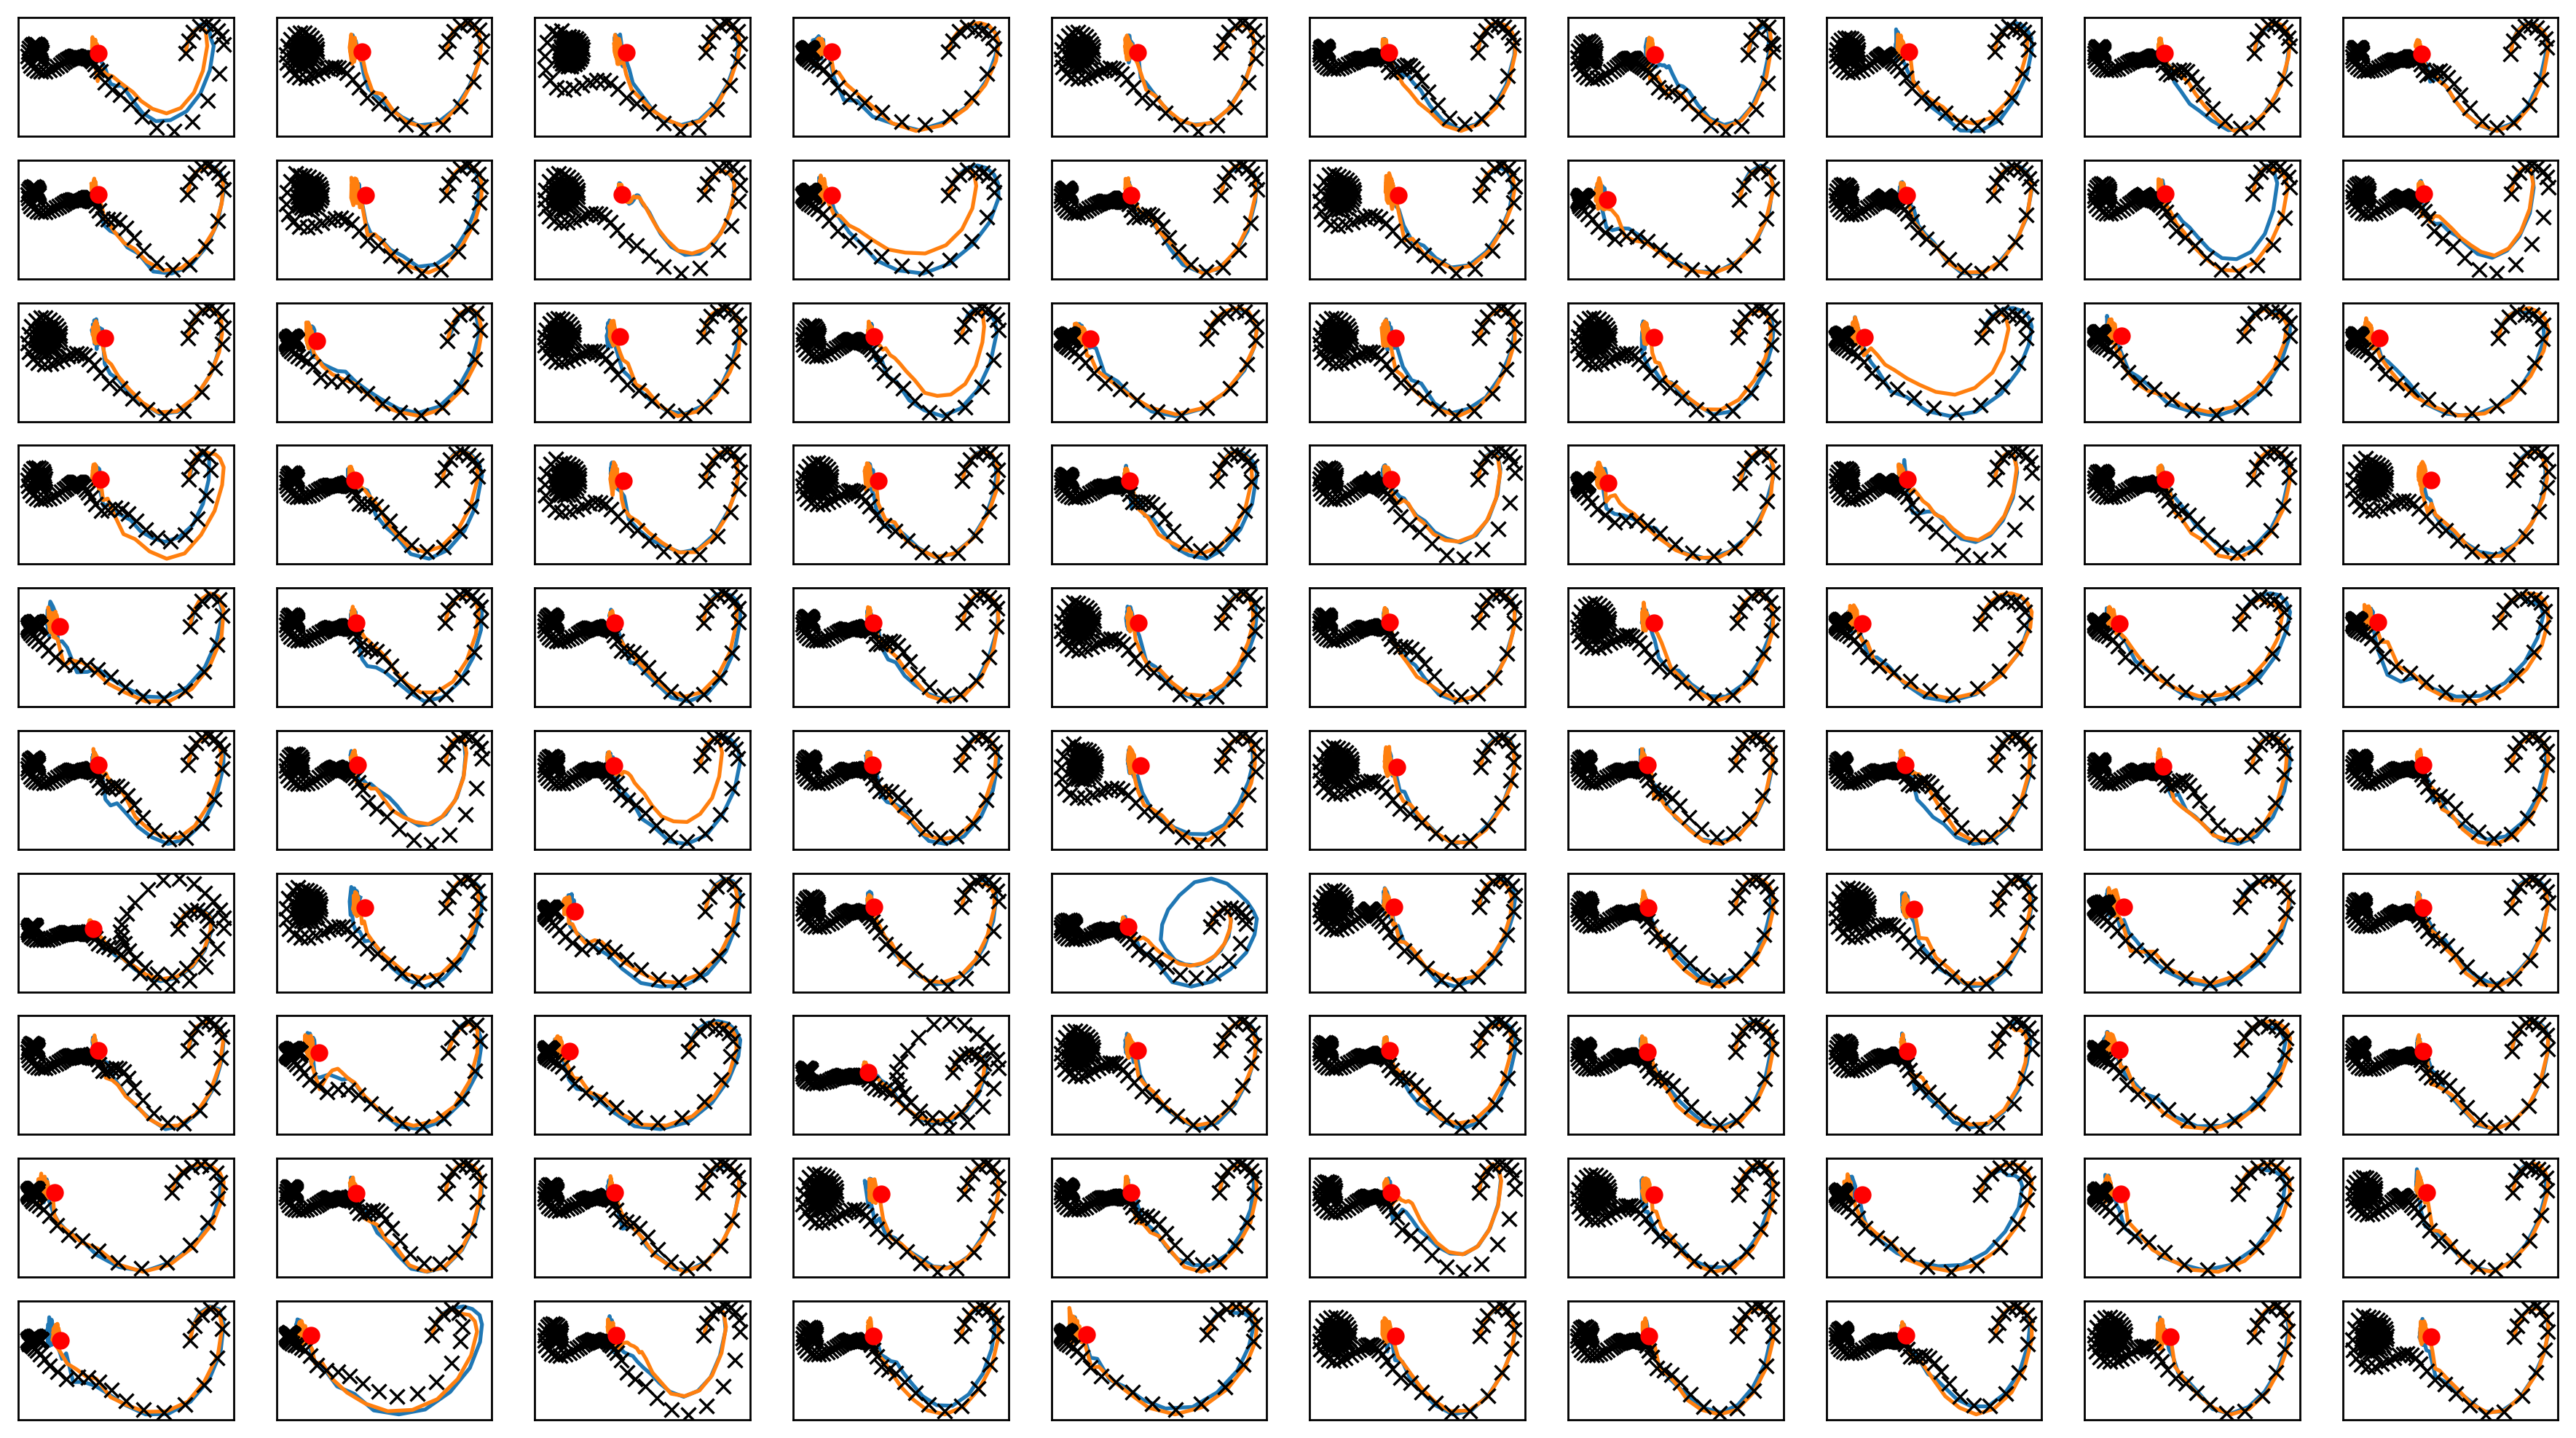

In [9]:

fig = plt.figure(figsize=(18,10), dpi=250)
fig.patch.set_facecolor('white')
ax_list = []
for i in range(len(offline_data)):
    ax_list.append(fig.add_subplot(len(offline_data)//10, 10, i+1))
    ax_list[-1].set_xticks([])
    ax_list[-1].set_yticks([])
#     ax_list[-1].plot(iwvi.offline_data[i][:,0], iwvi.offline_data[i][:,1],"kx") 
#     ax_list[-1].plot(iwvi.simenv_rolloutdata[i][:,0], iwvi.simenv_rolloutdata[i][:,1],"o") 
    ax_list[-1].plot(simdata0a[i][:,0], simdata0a[i][:,1]) 
    ax_list[-1].plot(simdata0b[i][:,0], simdata0b[i][:,1]) 
#     ax_list[-1].plot(simdata0c[i][:,0], simdata0c[i][:,1]) 

    ax_list[-1].plot(iwvi.debug_realenv_rolloutdata[i][:,0], iwvi.debug_realenv_rolloutdata[i][:,1],"kx")
    ax_list[-1].plot(0, 0,"ro")
plt.savefig(figfilenamehead+"iter0.png")
# plt.savefig(figfilenamehead+"iter0.pdf")
plt.savefig(figfilenamehead+"iter0.eps")
print("実環境方策rollout vs Sim環境方策rollout")

In [10]:
print(datetime.datetime.now())

2023-06-13 08:47:07.766769
